In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Perceptron, SGDClassifier
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

In [2]:
plt.figure(figsize=(12, 8))
sns.set(font_scale=1.5)
sns.set(palette='RdYlGn')

<Figure size 864x576 with 0 Axes>

In [3]:
# !python -m pip install --upgrade numpy

In [4]:
df_train = pd.read_csv('D:/Study/Python/data-set/Titanic/train.csv')
df_test = pd.read_csv('D:/Study/Python/data-set/Titanic/test.csv')
df_train_orig = df_train.copy()
df_test_orig = df_test.copy()

In [5]:
df_train.agg({'Age':['mean', 'std']})

,Age
mean,29.699118
std,14.526497


In [6]:
df_train['Age'].agg(['mean', 'std'])

mean    29.699118
std     14.526497
Name: Age, dtype: float64

In [7]:
def fillna_cont_var_with_random_ranged_values(df, col, method='mean'):
    v_data = df.agg({col:[method, 'std']})[col]
    v_middle = v_data[method]
    v_std = v_data['std']
    v_null_count = df[col].isna().sum()
    v_rand_values = np.random.randint(v_middle - v_std, v_middle + v_std, size = v_null_count)
    v_slice = df[col].copy()
    v_slice[np.isnan(v_slice)] = v_rand_values
    df[col] = v_slice
    df[col] = df[col].astype(int)

In [8]:
def get_categorical_continuous_variable_names (df):
    col_cate=list()
    col_cont=list()

    for x, y in df.dtypes.to_dict().items():
        if str(y) in ['object', 'category']:
            col_cate.append(x.strip())
        else:
            col_cont.append(x.strip())
    return {'col_cont':sorted(col_cont), 'col_cate':sorted(col_cate)}

In [9]:
def get_categories_to_consider(data, col, threshold=10):
    cat_list=[]
    count_per = data[col].count()
    for x,y in df_train.groupby([col]).size().sort_values(ascending=False).to_dict().items():
        if y/count_per*100 >= threshold:
            cat_list.append(x)
        else:
            break
    return sorted(cat_list[:20])

In [10]:
def labelize_column_data(df, col, threshold=10):
    cat_values = get_categories_to_consider(df, col, threshold)
    df[col] = df[col].apply(lambda x: x if x in cat_values else 'Others').astype(str)

In [11]:
def plot_heat_map(df, figsize=(10,10)):
    plt.figure(figsize=figsize)
    #fig=plt.gcf()
    #fig.set_size_inches(20,12)
    ax = sns.heatmap(data=df, annot=True, cmap='RdYlGn',linewidths=0.2, vmax=1, vmin=-1, center=0, square=True, annot_kws={'size':15})
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=45, verticalalignment='center')
    plt.show()

In [12]:
def encode_df_column_per_frequency(df_train, df_test, col):
    name_count_dict_1 = df_train.groupby([col]).size().sort_values().to_dict()
    key_dict={}
    for x, y in name_count_dict_1.items():
        key_list = key_dict.get(y)
        if key_list is None:
            key_list = list()
            key_dict[y] = key_list
        key_list.append(x)
    name_count_dict = {y:x for x, y in enumerate(key_dict)}
    name_count_dict_2 = {}
    for x, y in list(enumerate(key_dict)):
        for k in key_dict[y]:
            name_count_dict_2[k] = x
    df_train[col] = df_train[col].apply(lambda x: name_count_dict_2[x])
    df_test[col] = df_test[col].apply(lambda x: name_count_dict_2.get(x))

In [13]:
def normalize_with_standard_scaler(df, col):
    std_scaler = StandardScaler()
    df[col] = std_scaler.fit_transform(df[col].values.reshape(-1, 1))

In [14]:
def predict_calculate_print_accuracy(model, X_train, X_test, y_train, y_test):
    model_name = str(model).split('(')[0]
    model.fit(X_train,y_train)
    y_pred=model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(model_name)
    print(f"Model Accuracy: {round(model.score(X_train, y_train) * 100.0, 2)}")
    print(f"Prediction Accuracy: {round(accuracy * 100.0, 2)}")
    print()
    cf_matrix = confusion_matrix(y_test, y_pred)
    print(cf_matrix)
    print()
    print(classification_report(y_test, y_pred))
    ax = sns.heatmap(cf_matrix,annot=True,fmt='3.0f',cmap="RdYlGn")
    ax.set_title(model_name)
    plt.show()

In [15]:
def predict_and_output_results(model, file_path):
    result = model.predict(test_data)
    result_df = pd.DataFrame(result, columns=['Survived'])
    final_result_df = pd.concat([df_test_orig[['PassengerId']], result_df], axis=1)
    final_result_df.to_csv(file_path, index=False)

In [16]:
for x in df_train.dtypes:
    print(str(x))
    
    
get_categorical_continuous_variable_names(df_train)


int64
int64
int64
object
object
float64
int64
int64
object
float64
object
object


{'col_cont': ['Age',
  'Fare',
  'Parch',
  'PassengerId',
  'Pclass',
  'SibSp',
  'Survived'],
 'col_cate': ['Cabin', 'Embarked', 'Name', 'Sex', 'Ticket']}

In [17]:
for data in [df_train, df_test]:
    fillna_cont_var_with_random_ranged_values(data, 'Age', 'mean')
    fillna_cont_var_with_random_ranged_values(data, 'Fare', 'mean')

In [18]:
df_train['Age'].isna().sum()

0

In [19]:
pd.cut(df_train['Fare'], bins=[0, 7, 14, 35, 1000], labels=[1, 2, 3, 4]).value_counts().sort_index()

1    226
2    216
3    240
4    194
Name: Fare, dtype: int64

In [20]:
df_train['Fare_cat'] = pd.cut(df_train['Fare'].astype(int), bins=[-10000, 7, 14, 35, 10000], labels=[1, 2, 3, 4])
df_test['Fare_cat'] = pd.cut(df_test['Fare'].astype(int), bins=[-10000, 7, 14, 35, 10000], labels=[1, 2, 3, 4])

In [21]:
df_test['Fare'].isna().sum()

0

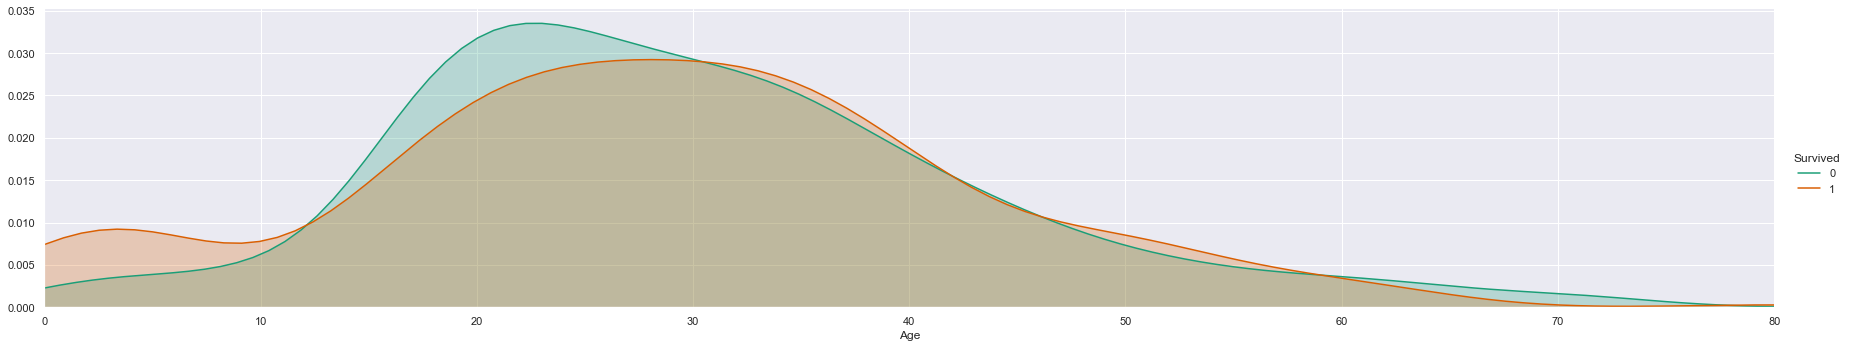

In [22]:
fg = sns.FacetGrid(df_train, hue='Survived', palette='Dark2', height=5, aspect=5)
fg.map(sns.kdeplot, 'Age', shade=True).add_legend()
fg.set(xlim=(0,df_train['Age'].max()))


In [23]:
df_corr = df_train.corr()
df_corr

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.022673,-0.057527,-0.001652,0.012668
Survived,-0.005007,1.000000,-0.338481,-0.050883,-0.035322,0.081629,0.257482
Pclass,-0.035144,-0.338481,1.000000,-0.328525,0.083081,0.018443,-0.550553
Age,0.022673,-0.050883,-0.328525,1.000000,-0.230987,-0.166269,0.089276
SibSp,-0.057527,-0.035322,0.083081,-0.230987,1.000000,0.414838,0.159506
Parch,-0.001652,0.081629,0.018443,-0.166269,0.414838,1.000000,0.216252
Fare,0.012668,0.257482,-0.550553,0.089276,0.159506,0.216252,1.000000


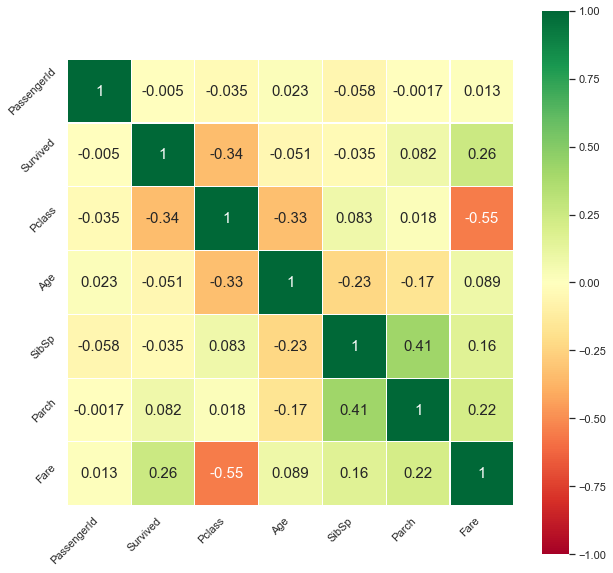

In [24]:
plot_heat_map(df_corr)

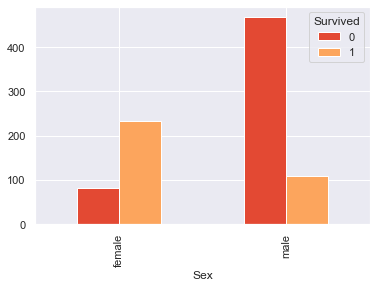

In [25]:
df_train.groupby(['Sex', 'Survived']).size().unstack().plot(kind='bar')

In [26]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  891 non-null    int64   
 1   Survived     891 non-null    int64   
 2   Pclass       891 non-null    int64   
 3   Name         891 non-null    object  
 4   Sex          891 non-null    object  
 5   Age          891 non-null    int32   
 6   SibSp        891 non-null    int64   
 7   Parch        891 non-null    int64   
 8   Ticket       891 non-null    object  
 9   Fare         891 non-null    int32   
 10  Cabin        204 non-null    object  
 11  Embarked     889 non-null    object  
 12  Fare_cat     891 non-null    category
dtypes: category(1), int32(2), int64(5), object(5)
memory usage: 77.8+ KB


In [27]:
df_train.describe(include = ['object'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Watt, Mrs. James (Elizabeth ""Bessie"" Inglis Mi...",male,1601,B96 B98,S
freq,1,577,7,4,644


In [28]:
key, value = list(df_train.groupby(['Embarked']).size().sort_values(ascending=False).to_dict().items())[0]
key, value

('S', 644)

In [29]:
df_train['Embarked'].fillna(df_train['Embarked'].describe()['top'], inplace=True)
df_test['Embarked'].fillna(df_train['Embarked'].describe()['top'], inplace=True)

df_train['Embarked'].unique()

array(['S', 'C', 'Q'], dtype=object)

In [30]:
df_train.groupby(['Survived', 'Embarked']).size().unstack()

Embarked,C,Q,S
Survived,,,
0,75,47,427
1,93,30,219


In [31]:
def find_person_type(age_sex):
    age, sex = age_sex
    if age <= 16:
        return 'child'
    else:
        return sex
    
df_train['Person'] = df_train[['Age', 'Sex']].apply(find_person_type, axis=1)
df_test['Person'] = df_test[['Age', 'Sex']].apply(find_person_type, axis=1)

In [32]:
df_train['Age'].describe()[['min', 'max']]

min     0.0
max    80.0
Name: Age, dtype: float64

In [33]:
age_dict = df_train.groupby(['Sex', 'Pclass']).apply(lambda x:x.agg({'Age':'median'}))['Age'].to_dict()
age_dict

{('female', 1): 33.5,
 ('female', 2): 28.5,
 ('female', 3): 24.0,
 ('male', 1): 37.0,
 ('male', 2): 30.0,
 ('male', 3): 25.0}

In [34]:
sex_pclass_age_dict = df_train.groupby(['Sex', 'Pclass'])['Age'].median().to_dict()
sex_pclass_age_dict

{('female', 1): 33.5,
 ('female', 2): 28.5,
 ('female', 3): 24.0,
 ('male', 1): 37.0,
 ('male', 2): 30.0,
 ('male', 3): 25.0}

In [35]:
df_train['Age_d'] = df_train.apply(lambda x:sex_pclass_age_dict[(x['Sex'], x['Pclass'])] if pd.isna(x['Age']) else x['Age'], axis=1)
df_test['Age_d'] = df_test.apply(lambda x:sex_pclass_age_dict[(x['Sex'], x['Pclass'])] if pd.isna(x['Age']) else x['Age'], axis=1)

In [36]:
df_train['Age_g'] = pd.cut(df_train['Age_d'], range(0, 101, 5)).apply(lambda x:f'{x.left+1}-{x.right}')
df_test['Age_g'] = pd.cut(df_test['Age_d'], range(0, 101, 5)).apply(lambda x:f'{x.left+1}-{x.right}')

In [37]:
df_train['Age_cat'] = pd.cut(df_train['Age_d'], bins=[0, 16, 40, 60, 100], labels=['Child', 'Young', 'Adult', 'Old'])
df_test['Age_cat'] = pd.cut(df_test['Age_d'], bins=[0, 16, 40, 60, 100], labels=['Child', 'Young', 'Adult', 'Old'])

In [38]:
df_train['Title'] = df_train['Name'].apply(lambda x: x.split(".")[0].split(",")[1].strip())
df_test['Title'] = df_test['Name'].apply(lambda x: x.split(".")[0].split(",")[1].strip())
print(df_train['Title'].unique())
df_test['Title'].unique()

['Mr' 'Mrs' 'Miss' 'Master' 'Don' 'Rev' 'Dr' 'Mme' 'Ms' 'Major' 'Lady'
 'Sir' 'Mlle' 'Col' 'Capt' 'the Countess' 'Jonkheer']


array(['Mr', 'Mrs', 'Miss', 'Master', 'Ms', 'Col', 'Rev', 'Dr', 'Dona'],
      dtype=object)

In [39]:
df_train.loc[(df_train['Title'].isin(['Mme', 'Mlle', 'Ms'])), 'Title'] = 'Miss'
df_test.loc[(df_test['Title'].isin(['Mme', 'Mlle', 'Ms'])), 'Title'] = 'Miss'



df_train.groupby('Title').agg({'Title':'count'}).rename({'Title':'occurences'}, axis=1).sort_values('occurences', ascending=False)

,occurences
Title,
Mr,517
Miss,186
Mrs,125
Master,40
Dr,7
Rev,6
Col,2
Major,2
Capt,1


In [40]:
title_unique = get_categories_to_consider(df_train, 'Title', 4)
title_unique

['Master', 'Miss', 'Mr', 'Mrs']

In [41]:
df_train['Title'] = df_train.apply(lambda x:'Others' if x['Title'] not in title_unique else x['Title'], axis=1)
df_test['Title'] = df_test.apply(lambda x:'Others' if x['Title'] not in title_unique else x['Title'], axis=1)

In [42]:
df_train['FamilySize'] = df_train.apply(lambda row:row['Parch']+row['SibSp']+1, axis=1)
df_test['FamilySize'] = df_test.apply(lambda row:row['Parch']+row['SibSp']+1, axis=1)

In [43]:
get_categorical_continuous_variable_names(df_train)

{'col_cont': ['Age',
  'Age_d',
  'FamilySize',
  'Fare',
  'Parch',
  'PassengerId',
  'Pclass',
  'SibSp',
  'Survived'],
 'col_cate': ['Age_cat',
  'Age_g',
  'Cabin',
  'Embarked',
  'Fare_cat',
  'Name',
  'Person',
  'Sex',
  'Ticket',
  'Title']}

In [44]:
list(filter(lambda x:x not in df_train.columns, df_test.columns))

[]

In [45]:
list(filter(lambda x:x not in df_test.columns, df_train.columns))

['Survived']

In [46]:
cat_embarked = get_categories_to_consider(df_train, 'Embarked', 10)
df_train['Embarked'].apply(lambda x: x if x in cat_embarked else 'Others')

0           S
1           C
2           S
3           S
4           S
        ...  
886         S
887         S
888         S
889         C
890    Others
Name: Embarked, Length: 891, dtype: object

In [47]:
#col_names_to_encode=['Embarked', 'Person', 'Pclass', 'Title']
#col_names_to_scale=['Age_d', 'FamilySize']
col_names_to_encode=['Embarked', 'Sex', 'Pclass', 'Title', 'Fare_cat']
col_names_to_scale=['Age', 'SibSp', 'FamilySize']

col_names_to_keep = col_names_to_encode.copy()
col_names_to_keep.extend(col_names_to_scale)
col_names_to_keep.append('Survived')
#col_names_to_keep.extend(['Age_d', 'Survived'])

In [48]:
for x in col_names_to_encode:
    labelize_column_data(df_train, x, 2)

In [49]:
for x in col_names_to_encode:
    print(x, '::', df_train[x].unique().astype(str))

Embarked :: ['S' 'C' 'Q']
Sex :: ['male' 'female']
Pclass :: ['3' '1' '2']
Title :: ['Mr' 'Mrs' 'Miss' 'Master' 'Others']
Fare_cat :: ['1' '4' '2' '3']


In [50]:
for df in [df_train, df_test]:
    for col in col_names_to_scale:
        normalize_with_standard_scaler(df, col)

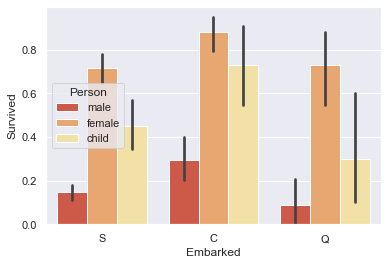

In [51]:
sns.barplot(data=df_train, x='Embarked', y='Survived', hue='Person')

In [52]:
df_train['Age_d'].isna().sum()

0

In [53]:
columns_to_drop = sorted([x for x in df_train.columns if x not in col_names_to_keep])
columns_to_drop

['Age_cat',
 'Age_d',
 'Age_g',
 'Cabin',
 'Fare',
 'Name',
 'Parch',
 'PassengerId',
 'Person',
 'Ticket']

In [54]:
df_train.drop(columns_to_drop, axis=1, inplace=True)
df_test.drop(columns_to_drop, axis=1, inplace=True)

In [55]:
df_train.isna().any(), df_train.isna().sum().sum()

(Survived      False
 Pclass        False
 Sex           False
 Age           False
 SibSp         False
 Embarked      False
 Fare_cat      False
 Title         False
 FamilySize    False
 dtype: bool,
 0)

In [56]:
df_test.isna().any(), df_test.isna().sum().sum()

(Pclass        False
 Sex           False
 Age           False
 SibSp         False
 Embarked      False
 Fare_cat      False
 Title         False
 FamilySize    False
 dtype: bool,
 0)

In [57]:
df_grouped_temp = df_train.groupby(col_names_to_keep).size().unstack()
df_grouped_temp

Survived                                                                0    1
Embarked Sex    Pclass Title Fare_cat Age       SibSp     FamilySize          
C        female 1      Miss  3         0.042315 -0.474545 -0.560975   NaN  1.0
                                       1.520852 -0.474545 -0.560975   1.0  NaN
                             4        -0.992661 -0.474545  0.059160   NaN  1.0
                                      -0.844807  1.340132  1.919564   NaN  1.0
                                      -0.623027  1.340132  1.919564   NaN  1.0
...                                                                   ...  ...
S        male   3      Mr    4        -0.253392 -0.474545 -0.560975   NaN  1.0
                                      -0.105539 -0.474545 -0.560975   1.0  1.0
                                       0.190169 -0.474545 -0.560975   NaN  2.0
                                       0.338023  6.784163  5.640372   1.0  NaN
                                       0.707657  6.784163  5.640372   1.0  NaN

[680 rows x 2 columns]

df_train = pd.get_dummies(df_train, columns=col_names_to_encode, drop_first=True)
df_test = pd.get_dummies(df_test, columns=col_names_to_encode, drop_first=True)
df_train.head()

In [58]:
df_others = {col:'Others' for col in col_names_to_encode}
oe = OrdinalEncoder().fit(df_train[col_names_to_encode].append(df_others, ignore_index=True).astype(str))


In [59]:
df_train_oe = pd.DataFrame(oe.transform(df_train[col_names_to_encode].astype(str)), columns=col_names_to_encode)
df_test_oe = pd.DataFrame(oe.transform(df_test[col_names_to_encode].astype(str)), columns=col_names_to_encode)

In [60]:
df_train_oe.head()

,Embarked,Sex,Pclass,Title,Fare_cat
0,3.0,2.0,2.0,2.0,0.0
1,0.0,1.0,0.0,3.0,3.0
2,3.0,1.0,2.0,1.0,0.0
3,3.0,1.0,0.0,3.0,3.0
4,3.0,2.0,2.0,2.0,1.0


In [61]:
#ohe = OneHotEncoder(handle_unknown='ignore').fit(df_train_oe[col_names_to_encode])
ohe = OneHotEncoder(sparse=False).fit(df_train_oe[col_names_to_encode])
ohe

OneHotEncoder(sparse=False)

In [62]:
#df_train_ohe = pd.DataFrame(ohe.transform(df_train_oe[col_names_to_encode]).todense())
#df_test_ohe = pd.DataFrame(ohe.transform(df_test_oe[col_names_to_encode]).todense())
df_train_ohe = pd.DataFrame(ohe.transform(df_train_oe[col_names_to_encode]))
df_test_ohe = pd.DataFrame(ohe.transform(df_test_oe[col_names_to_encode]))



In [63]:
df_train_encoded = pd.concat([df_train, df_train_ohe], axis=1)
df_train_encoded.drop(columns=col_names_to_encode, axis=1, inplace=True)

df_test_encoded = pd.concat([df_test, df_test_ohe], axis=1)
df_test_encoded.drop(columns=col_names_to_encode, axis=1, inplace=True)

In [64]:
corr = df_train_encoded.corr()
corr

,Survived,Age,SibSp,FamilySize,0,1,2,3,4,5,...,7,8,9,10,11,12,13,14,15,16
Survived,1.000000,-0.050883,-0.035322,0.016639,0.168240,0.003650,-0.149683,0.543351,-0.543351,0.285904,...,-0.322308,0.085221,0.338468,-0.549199,0.339040,-0.012054,-0.210437,-0.112599,0.082604,0.254630
Age,-0.050883,1.000000,-0.230987,-0.240937,0.029307,-0.027145,-0.008592,-0.058924,0.058924,0.311251,...,-0.283743,-0.363467,-0.226717,0.159198,0.174296,0.178502,-0.040916,-0.022723,-0.028171,0.097916
SibSp,-0.035322,-0.230987,1.000000,0.890712,-0.059528,-0.026354,0.068734,0.114631,-0.114631,-0.054582,...,0.092548,0.349559,0.081986,-0.250489,0.063407,-0.025874,-0.238520,-0.206661,0.184736,0.272746
FamilySize,0.016639,-0.240937,0.890712,1.000000,-0.046215,-0.058592,0.077359,0.200988,-0.200988,-0.046114,...,0.071142,0.372472,0.105738,-0.338014,0.156168,-0.047426,-0.296144,-0.234507,0.257133,0.285862
0,0.168240,0.029307,-0.059528,-0.046215,1.000000,-0.148258,-0.782742,0.082853,-0.082853,0.296423,...,-0.153329,-0.035225,0.041861,-0.072567,0.061395,0.030095,-0.073902,-0.132082,-0.027505,0.246261
1,0.003650,-0.027145,-0.026354,-0.058592,-0.148258,1.000000,-0.499421,0.074115,-0.074115,-0.155342,...,0.237449,0.010478,0.166350,-0.078338,-0.089739,0.000311,0.271313,-0.118060,-0.024677,-0.142906
2,-0.149683,-0.008592,0.068734,0.077359,-0.782742,-0.499421,1.000000,-0.119224,0.119224,-0.161921,...,-0.015104,0.024264,-0.141356,0.112870,0.002689,-0.026561,-0.105997,0.190004,0.039624,-0.125804
3,0.543351,-0.058924,0.114631,0.200988,0.082853,0.074115,-0.119224,1.000000,-1.000000,0.098013,...,-0.137143,-0.159934,0.696282,-0.867334,0.547600,-0.075638,-0.195325,-0.055485,0.092257,0.168681
4,-0.543351,0.058924,-0.114631,-0.200988,-0.082853,-0.074115,0.119224,-1.000000,1.000000,-0.098013,...,0.137143,0.159934,-0.696282,0.867334,-0.547600,0.075638,0.195325,0.055485,-0.092257,-0.168681
5,0.285904,0.311251,-0.054582,-0.046114,0.296423,-0.155342,-0.161921,0.098013,-0.098013,1.000000,...,-0.626738,-0.084700,0.025190,-0.097288,0.088207,0.155640,-0.309076,-0.320000,0.010733,0.653418


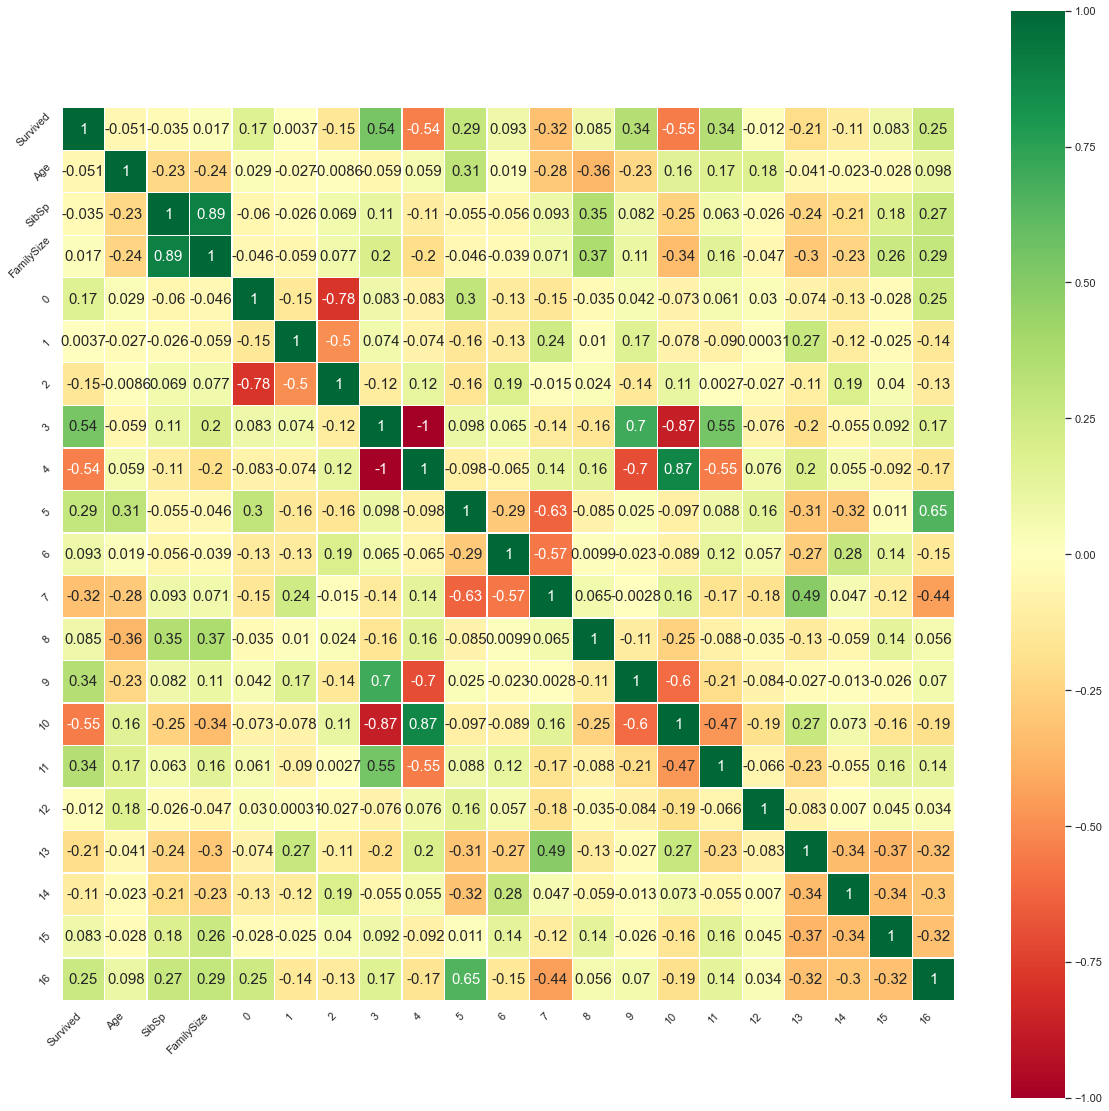

In [65]:
plot_heat_map(corr, figsize=(20, 20))

In [66]:
X = df_train_encoded
X

,Survived,Age,SibSp,FamilySize,0,1,2,3,4,5,...,7,8,9,10,11,12,13,14,15,16
0,0,-0.549100,0.432793,0.059160,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1,0.633730,0.432793,0.059160,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,1,-0.253392,-0.474545,-0.560975,0.0,0.0,1.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1,0.411949,0.432793,0.059160,0.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0,0.411949,-0.474545,-0.560975,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,-0.179466,-0.474545,-0.560975,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
887,1,-0.770881,-0.474545,-0.560975,0.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
888,0,-0.770881,0.432793,1.299429,0.0,0.0,1.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
889,1,-0.253392,-0.474545,-0.560975,1.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [67]:
y = X['Survived']
X.drop('Survived', inplace=True, axis=1)
y

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int64

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=207)

In [69]:
X_train

,Age,SibSp,FamilySize,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
665,0.190169,1.340132,0.679295,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
384,0.485876,-0.474545,-0.560975,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
699,0.929437,-0.474545,-0.560975,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
511,-0.105539,-0.474545,-0.560975,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
508,-0.105539,-0.474545,-0.560975,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,0.042315,-0.474545,-0.560975,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
78,-2.175491,-0.474545,0.679295,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
416,0.338023,0.432793,0.679295,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
562,-0.105539,-0.474545,-0.560975,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [70]:
test_data=df_test_encoded[X_test.columns]
test_data.isna().sum().sum()

0

### this takes almost 30 min to execute, hence commenting out
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
n_estimators = [100, 500, 1000]
max_features = ['sqrt', 'log2']
grid = dict(n_estimators=n_estimators,max_features=max_features)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print('Best Params: ', grid_result.best_params_)
#means = grid_result.cv_results_['mean_test_score']
#stds = grid_result.cv_results_['std_test_score']
#params = grid_result.cv_results_['params']
#for mean, stdev, param in zip(means, stds, params):
#    print("%f (%f) with: %r" % (mean, stdev, param))

In [71]:
log_regression_model = LogisticRegression(solver='lbfgs', C=10.0, random_state=0, max_iter=1000)

svc_classifier = svm.SVC(C=50.0, kernel='rbf', gamma='scale')

KNN_classifier = KNeighborsClassifier(n_neighbors=15)

naive_bayes_model = GaussianNB()


perceptron = Perceptron()

linear_SVC = LinearSVC()

sgd = SGDClassifier()


xgb_classifier_model = XGBClassifier(learning_rate=0.01, n_estimators=100, random_state=0, max_depth=6)



ridge_classifier = RidgeClassifier(alpha=0.1)

bagging_classifier = BaggingClassifier(n_estimators=10)

decision_tree = DecisionTreeClassifier()


clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='log2', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)
#clf_params = {'max_features': 'sqrt', 'n_estimators': 100, 'criterion':'gini'}
#clf = RandomForestClassifier(**clf_params)

model_list = [log_regression_model, svc_classifier, KNN_classifier, naive_bayes_model, perceptron, linear_SVC, sgd, xgb_classifier_model, ridge_classifier, bagging_classifier, decision_tree, clf]

for model in model_list:
    print(str(model).split('(')[0])

LogisticRegression
SVC
KNeighborsClassifier
GaussianNB
Perceptron
LinearSVC
SGDClassifier
XGBClassifier
RidgeClassifier
BaggingClassifier
DecisionTreeClassifier
RandomForestClassifier


LogisticRegression
Model Accuracy: 82.83
Prediction Accuracy: 85.07

[[78  8]
 [12 36]]

              precision    recall  f1-score   support

           0       0.87      0.91      0.89        86
           1       0.82      0.75      0.78        48

    accuracy                           0.85       134
   macro avg       0.84      0.83      0.83       134
weighted avg       0.85      0.85      0.85       134



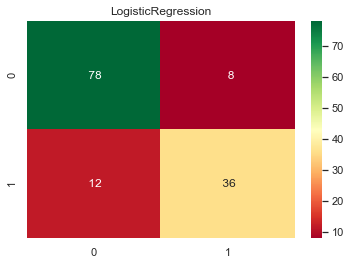

SVC
Model Accuracy: 89.04
Prediction Accuracy: 85.07

[[78  8]
 [12 36]]

              precision    recall  f1-score   support

           0       0.87      0.91      0.89        86
           1       0.82      0.75      0.78        48

    accuracy                           0.85       134
   macro avg       0.84      0.83      0.83       134
weighted avg       0.85      0.85      0.85       134



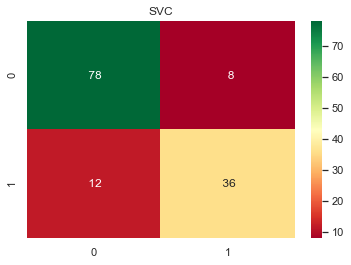

KNeighborsClassifier
Model Accuracy: 83.75
Prediction Accuracy: 84.33

[[77  9]
 [12 36]]

              precision    recall  f1-score   support

           0       0.87      0.90      0.88        86
           1       0.80      0.75      0.77        48

    accuracy                           0.84       134
   macro avg       0.83      0.82      0.83       134
weighted avg       0.84      0.84      0.84       134



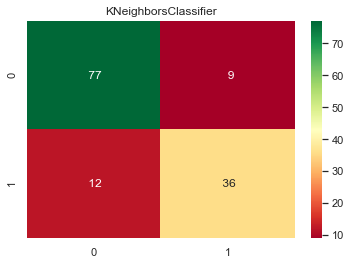

GaussianNB
Model Accuracy: 81.24
Prediction Accuracy: 81.34

[[72 14]
 [11 37]]

              precision    recall  f1-score   support

           0       0.87      0.84      0.85        86
           1       0.73      0.77      0.75        48

    accuracy                           0.81       134
   macro avg       0.80      0.80      0.80       134
weighted avg       0.82      0.81      0.81       134



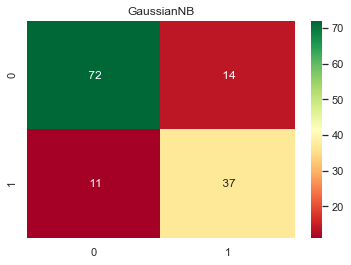

Perceptron
Model Accuracy: 79.26
Prediction Accuracy: 76.12

[[66 20]
 [12 36]]

              precision    recall  f1-score   support

           0       0.85      0.77      0.80        86
           1       0.64      0.75      0.69        48

    accuracy                           0.76       134
   macro avg       0.74      0.76      0.75       134
weighted avg       0.77      0.76      0.76       134



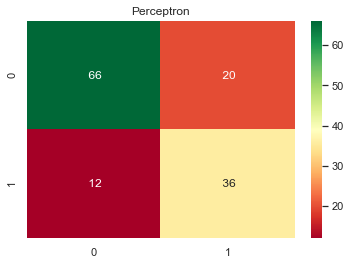

LinearSVC
Model Accuracy: 82.69
Prediction Accuracy: 83.58

[[77  9]
 [13 35]]

              precision    recall  f1-score   support

           0       0.86      0.90      0.88        86
           1       0.80      0.73      0.76        48

    accuracy                           0.84       134
   macro avg       0.83      0.81      0.82       134
weighted avg       0.83      0.84      0.83       134



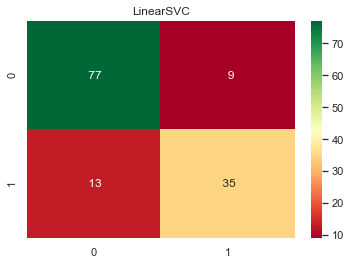

SGDClassifier
Model Accuracy: 81.37
Prediction Accuracy: 82.09

[[78  8]
 [16 32]]

              precision    recall  f1-score   support

           0       0.83      0.91      0.87        86
           1       0.80      0.67      0.73        48

    accuracy                           0.82       134
   macro avg       0.81      0.79      0.80       134
weighted avg       0.82      0.82      0.82       134



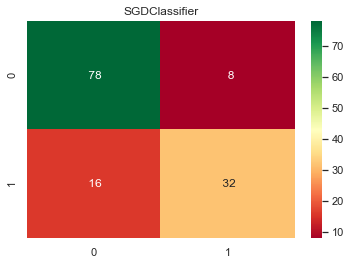

D:\Programs\Anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:29:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier
Model Accuracy: 87.05
Prediction Accuracy: 85.82

[[78  8]
 [11 37]]

              precision    recall  f1-score   support

           0       0.88      0.91      0.89        86
           1       0.82      0.77      0.80        48

    accuracy                           0.86       134
   macro avg       0.85      0.84      0.84       134
weighted avg       0.86      0.86      0.86       134



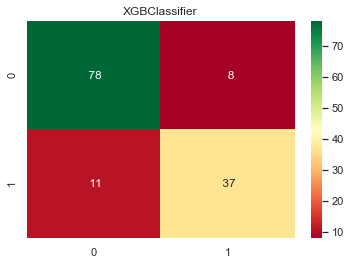

RidgeClassifier
Model Accuracy: 82.56
Prediction Accuracy: 83.58

[[76 10]
 [12 36]]

              precision    recall  f1-score   support

           0       0.86      0.88      0.87        86
           1       0.78      0.75      0.77        48

    accuracy                           0.84       134
   macro avg       0.82      0.82      0.82       134
weighted avg       0.83      0.84      0.84       134



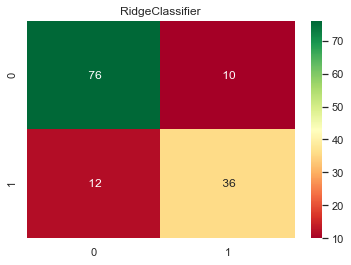

BaggingClassifier
Model Accuracy: 94.58
Prediction Accuracy: 85.07

[[75 11]
 [ 9 39]]

              precision    recall  f1-score   support

           0       0.89      0.87      0.88        86
           1       0.78      0.81      0.80        48

    accuracy                           0.85       134
   macro avg       0.84      0.84      0.84       134
weighted avg       0.85      0.85      0.85       134



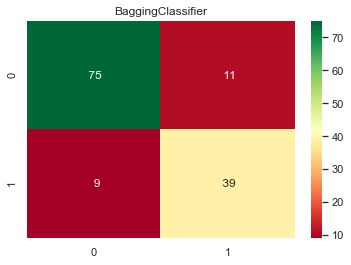

DecisionTreeClassifier
Model Accuracy: 95.77
Prediction Accuracy: 80.6

[[75 11]
 [15 33]]

              precision    recall  f1-score   support

           0       0.83      0.87      0.85        86
           1       0.75      0.69      0.72        48

    accuracy                           0.81       134
   macro avg       0.79      0.78      0.78       134
weighted avg       0.80      0.81      0.80       134



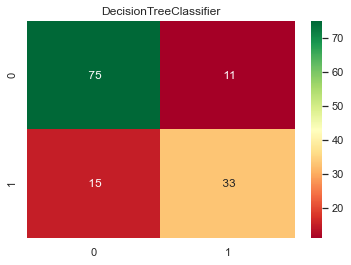

RandomForestClassifier
Model Accuracy: 88.11
Prediction Accuracy: 86.57

[[79  7]
 [11 37]]

              precision    recall  f1-score   support

           0       0.88      0.92      0.90        86
           1       0.84      0.77      0.80        48

    accuracy                           0.87       134
   macro avg       0.86      0.84      0.85       134
weighted avg       0.86      0.87      0.86       134



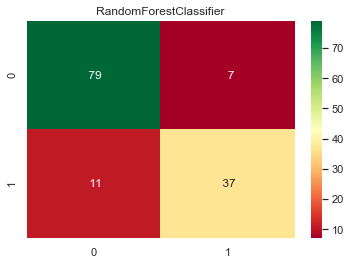

In [72]:
for model in model_list:
    predict_calculate_print_accuracy(model, X_train, X_test, y_train, y_test)
    model_name = str(model).split('(')[0]
    file_path = f'D:/Study/Python/Projects/Titanic_Passengers_Survival_Predictions_{model_name}.csv'
    predict_and_output_results(model, file_path)

### This too takes almost 20 minutes... so commenting out
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
model = GradientBoostingClassifier()
n_estimators = [10, 100, 1000]
learning_rate = [0.001, 0.01, 0.1]
subsample = [0.5, 0.7, 1.0]
max_depth = [3, 7, 9]
grid = dict(learning_rate=learning_rate, n_estimators=n_estimators, subsample=subsample, max_depth=max_depth)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier
model = BaggingClassifier()
n_estimators = [10, 100, 1000]
grid = dict(n_estimators=n_estimators)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
penalty = ['l1', 'l2', 'elasticnet', 'none']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import RidgeClassifier
model = RidgeClassifier()
alpha = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
grid = dict(alpha=alpha)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier()
n_neighbors = range(1, 21, 2)
weights = ['uniform', 'distance']
metric = ['euclidean', 'manhattan', 'minkowski']

grid = dict(n_neighbors=n_neighbors,weights=weights,metric=metric)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
model = SVC()
kernel = ['poly', 'rbf', 'sigmoid']
C = [100, 50, 10, 1.0, 0.1, 0.01]
gamma = ['scale']
grid = dict(kernel=kernel,C=C,gamma=gamma)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))